# Modelos QSAR-SVM para protease principal 3C-like protease (M<sup>pro</sup>) de SARS-CoV

Os modelos nesse fluxo de trabalho foram criados usando as PaDEL-Descriptor, Impressões digitais de Morgan, SiRMS (Simplex Representation of Molecular Structure) e Drangon 7.0 com SVM scikit-learn.

## Importando Módulos e Funções

In [1]:
# Funções
from functions.BalanceBySim import *
from functions.DescritoresMorgan import morgan_descriptors
from functions.DescritoresPaDEL import padel_descriptors
from functions.DescritoresSiRMS import sirms_descriptors
from functions.DescritoresDragon import dragon_descriptors
from functions.stats import stats
from functions.CarregarDadosAD import carregar_dados_ad
from functions.RocAUC import roc_auc
from functions.YRandomization import y_randomization
from functions.BestModel import grid_search, random_search, best_grid_search, best_random_search
from functions.Evaluation import statistics
from functions.StatsChart import print_stats
from functions.CarregarDados import carregar_dados
from functions.Consenso import statistics_morganXpadel, statistics_sirmsXdragon
from functions.ConsensoChart import print_consenso
from functions.ComparisonHyperparameters import compare
import scipy
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

## Carregar compostos inibidores (Y)

Original data:  (113, 11)
Dados mantidos:  (113, 11)
Forma do conjunto de treinamento:

		 Classe 1: 40
		 Classe 0: 73
		 Número total de compostos: 113
Class labels: [Counter({0: 73, 1: 40})]


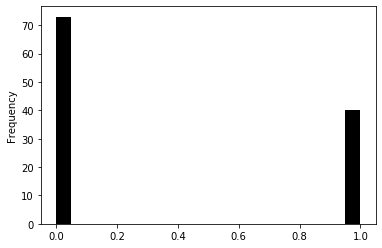

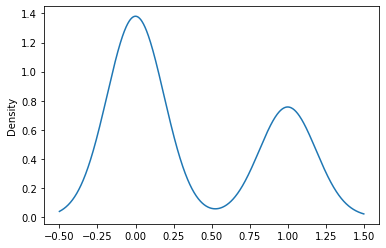

In [2]:
moldf = carregar_dados();
moldf.plot(kind="hist", legend=None, bins=20, color='k')
moldf.plot(kind="kde", legend=None);

### Carregar compostos inibidores 7 moleculas do dominio (Y)

Original data:  (7, 6)
Dados mantidos:  (7, 6)
Forma do conjunto de treinamento:

		 Classe 1: 3
		 Classe 0: 4
		 Número total de compostos: 7
Class labels: [Counter({0: 4, 1: 3})]


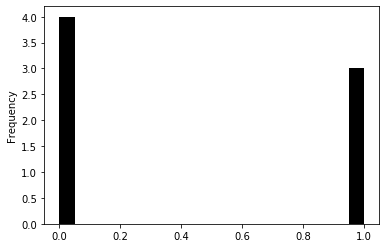

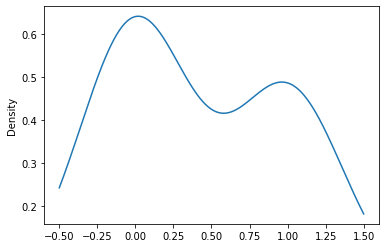

In [3]:
moldfad = carregar_dados_ad();
moldfad.plot(kind="hist", legend=None, bins=20, color='k')
moldfad.plot(kind="kde", legend=None);

## Gerando conjunto de treinamento e teste a partir dos descritores (X)

#### Função Fingerprints de Harry Morgan

In [4]:
data_morgan = morgan_descriptors(moldfad)
Y_train_morgan = data_morgan['Y_train']
X_train_morgan = data_morgan['X_train']
X_train_morgan.shape

Forma do conjunto de treinamento:

		 Classe 1: 3
		 Classe 0: 4
		 Número total de compostos: 7
Class labels: [Counter({0: 4, 1: 3})]
Forma do conjunto de treinamento: Counter({0: 4, 1: 3})
Forma externa definida: Counter()


(7, 2048)

#### PaDEL-Descriptor

In [ ]:
data_padel = padel_descriptors(moldf)
Y_train_padel = data_padel['Y_train']
X_train_padel = data_padel['X_train']
X_train_padel.shape

## Parâmetros p/ geração dos modelos

#### Parâmetros SVM

In [6]:
from scipy.stats import expon, randint
# Grade de parametros
svm_param = {
    "C": [0.001, 0.01, 0.1, 1, 10],
    "gamma": [0.1, 5, 10],
    "kernel": ['rbf', 'linear', 'poly'],
    "random_state": [24]
}

# Distribuição de parametros
svm_dist = {
    "C": randint(.001,10),
    "gamma": randint(.1,10),
    "kernel": ['rbf', 'linear', 'poly'],
    "random_state": [24]
}

## Otimizando hiperparâmetros

#### Padel

In [11]:
compare(SVC(), X_train_morgan, Y_train_morgan, svm_param, svm_dist, 'Morgan', 'SVM')

Fitting 5 folds for each of 45 candidates, totalling 225 fits


ValueError: n_splits=5 cannot be greater than the number of members in each class.

## Otimizando hiperparâmetros

#### Criando modelos a partir  melhores parâmetros

In [12]:
#criando o modelo com os melhores parametros utilizando processamento paralelo
#{'C': 6, 'gamma': 9, 'kernel': 'poly', 'random_state': 24}
svm_best_morgan = SVC(C=6, gamma=9, random_state= 24, kernel='poly', probability=True)

svm_best_morgan.fit(X_train_morgan, Y_train_morgan)

SVC(C=6, gamma=9, kernel='poly', probability=True, random_state=24)

## Validação dos modelos

####  Área sob a curva ROC (AUC) 

In [13]:
pred = []
ad = []
index = []

fold_model = svm_best_morgan.fit(X_train_morgan, Y_train_morgan)
fold_pred = fold_model.predict(X_train_morgan)
fold_ad = fold_model.decision_function(X_train_morgan)
pred.append(fold_pred)
ad.append(fold_ad)
index.append(1)

In [14]:
threshold_ad = 0.8
fold_pred = np.concatenate(pred)
fold_ad = np.concatenate(ad)
fold_ad = (np.amax(fold_ad, axis=1) >= threshold_ad).astype(str)

AxisError: axis 1 is out of bounds for array of dimension 1

In [15]:
fold_ad

array([ 1.00004395,  1.0000439 , -1.00007432, -1.00007333,  0.99951146,
       -0.99972546, -0.99972616])